In [1]:
#Bolivia Small Group Project (adopted from Laos Small Group Project : https://github.com/jfoxford/Laos-Small-Group-2022/blob/main/Laos_Python_Model.ipynb

#This python script models the Bolivian power network in 2050 following the Net-Zero Scenario data proposed by the team. 
#The domestic network is divided into the 8 departments of Bolivia, and generation is distributed along them according to previously identified
#renewable energy potential and land constraints together with population density.

#Domestic demand in 2050 is about 12.08GW in 2050 which is distributed across all the 8 departments proportionally to population
#Nominal national voltage is assumed to be 230kV but each of the busses' nominal voltage is based on the government's existing infrastructure 

#All input parameters are available in the excel sheet "Bolivia Python Model Inputs" also available in the same GitHub folder

#the first section we run the model in an optimization mode to identify the optimal balance between online dispatchable capacity and line loading
#then we run the model based on the outcome of the optimization particularly 75% and 60% to see the in detail power flow analysis

In [2]:
# Import libraries
import pandas as pd
import pandapower as pp
from pandapower.plotting.plotly import simple_plotly
import numpy as np
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import seaborn


In [3]:
#create loop

df_loop = pd.DataFrame(columns=["dispatch_percentage", "max_loading"])
print(df_loop)

count = 0

for dispatch_perc in range(100,50,-5):
    # Create network
    net = pp.create_empty_network() 
    #Read bus data from excel
    bus_df=pd.read_excel(r"bolivia python input.xlsx", sheet_name='buses',nrows=15)
    #bus_df
    # Create buses
    b = {}

    for i in bus_df['bus_id']:
        b[i] = pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0]),min_vm_pu=0.85)
    net.bus

    # Create one grid connection point
    connect_bus = b[0] 
    vm_pu = 1.1

    # Create the external grid connection
    pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")

    # Import line data from excel file-- from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka

    line_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='lines',nrows=12)
    #line_df

    # Create lines
    for i in line_df.index:
        pp.create_line_from_parameters(net, from_bus=b[line_df.loc[i, 'from_bus']],
                                    to_bus=b[line_df.loc[i, 'to_bus']],
                                    length_km=line_df.loc[i, 'length_km'],
                                    r_ohm_per_km=line_df.loc[i, 'r_ohm_per_km'],
                                    x_ohm_per_km=line_df.loc[i, 'x_ohm_per_km'],
                                    c_nf_per_km=line_df.loc[i, 'c_nf_per_km'],
                                    max_i_ka=line_df.loc[i, 'max_i_ka']
                                    ) 
    net.line

    # Import Load data from excel-- geolocation, bus (nearest from geolocation), p_mw
    load_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='loads',nrows=9)
    #load_df

    # Create loads
    p_mw = 'power_p_mw'
    q_mvar = 'power_q_mvar'

    for i in load_df['bus_id']:
        pp.create_load(net, 
                    b[i], 
                    p_mw=load_df.loc[load_df['bus_id']==i, p_mw].values[0], 
                    q_mvar=load_df.loc[load_df['bus_id']==i, q_mvar].values[0],
                    name=load_df.loc[load_df['bus_id']==i, 'name'].values[0])
    
    net.bus

    # Generators imported from excel
    vm_pu=1.1

#### make the excel sheets in this style "gen 100"  "gen 95" etc. down from 100 to 50 in steps of 5
    gen_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='gen',nrows=9)
    print("sheet_name: ", 'gen ' + str(dispatch_perc))
    #gen_df  

    #Generators
    for i in gen_df['gen_id']:
        pp.create_gen(net, bus=gen_df.loc[gen_df['gen_id']==i, 'bus_id'].values[0],
                    p_mw=gen_df.loc[gen_df['gen_id']==i, 'p_mw_' + str(dispatch_perc)].values[0],vm_pu=1, 
                    name=gen_df.loc[gen_df['gen_id']==i, 'name'].values[0])
    net.gen

    #USE THIS FOR TRANSFORMER- total of 6 transformers are created
    # Define the voltage levels
    vk_percent = 12
    vkr_percent = 0.26
    pfe_kw = 3.2
    i0_percent = 0.06

    # Create the transformers where voltage changes
    pp.create_transformer_from_parameters(net, 0, 9, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
    pp.create_transformer_from_parameters(net, 10, 2, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
    pp.create_transformer_from_parameters(net, 3, 11, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
    pp.create_transformer_from_parameters(net, 6, 12, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
    pp.create_transformer_from_parameters(net, 13, 4, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
    pp.create_transformer_from_parameters(net, 14, 7, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)


    # Set the voltage setpoint of all generators at bus 0 to 1.0 p.u.
    net.gen.loc[net.gen.bus == 0, 'vm_pu'] = 1.0

    # Set the voltage setpoint of all external grids at bus 0 to 1.0 p.u.
    net.ext_grid.loc[net.ext_grid.bus == 0, 'vm_pu'] = 1.0

    # Set the voltage setpoint of all DC lines at bus 0 to 1.0 p.u.
    net.dcline.loc[net.dcline.from_bus == 0, 'vm_from_pu'] = 1.0
    net.dcline.loc[net.dcline.to_bus == 0, 'vm_to_pu'] = 1.0

    try:# Run the network using the NR algorithm
        pp.runpp(net, algorithm='nr', max_iteration=10000, numba=False);
    except: 
        print(str(dispatch_perc) + " did not work")
        continue

    net

    net.res_line


##### if there is a problem it is probably the following line
    max_loading = net.res_line["loading_percent"].max()

    df_loop.loc[count] = [dispatch_perc,max_loading]
    count += 1

print(df_loop)
    

Empty DataFrame
Columns: [dispatch_percentage, max_loading]
Index: []
sheet_name:  gen 100
sheet_name:  gen 95
sheet_name:  gen 90
sheet_name:  gen 85
sheet_name:  gen 80
sheet_name:  gen 75
sheet_name:  gen 70
sheet_name:  gen 65
sheet_name:  gen 60
sheet_name:  gen 55
55 did not work
   dispatch_percentage  max_loading
0                100.0   421.645203
1                 95.0   453.472382
2                 90.0   491.055910
3                 85.0   133.356971
4                 80.0   105.240861
5                 75.0    80.208393
6                 70.0    56.205049
7                 65.0    65.030070
8                 60.0    85.955266


In [4]:
print(df_loop)

df_loop.to_csv("dispatchable_capacity_online_vs_max_loading_perc.csv", index=False)

   dispatch_percentage  max_loading
0                100.0   421.645203
1                 95.0   453.472382
2                 90.0   491.055910
3                 85.0   133.356971
4                 80.0   105.240861
5                 75.0    80.208393
6                 70.0    56.205049
7                 65.0    65.030070
8                 60.0    85.955266


In [5]:
dispatch_perc = 75




# Create network
net = pp.create_empty_network() 
#Read bus data from excel
bus_df=pd.read_excel(r"bolivia python input.xlsx", sheet_name='buses',nrows=15)
#bus_df
# Create buses
b = {}

for i in bus_df['bus_id']:
    b[i] = pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0]),min_vm_pu=0.85)
net.bus

# Create one grid connection point
connect_bus = b[0] 
vm_pu = 1.1

# Create the external grid connection
pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")

# Import line data from excel file-- from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka

line_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='lines',nrows=12)
#line_df

# Create lines
for i in line_df.index:
    pp.create_line_from_parameters(net, from_bus=b[line_df.loc[i, 'from_bus']],
                                to_bus=b[line_df.loc[i, 'to_bus']],
                                length_km=line_df.loc[i, 'length_km'],
                                r_ohm_per_km=line_df.loc[i, 'r_ohm_per_km'],
                                x_ohm_per_km=line_df.loc[i, 'x_ohm_per_km'],
                                c_nf_per_km=line_df.loc[i, 'c_nf_per_km'],
                                max_i_ka=line_df.loc[i, 'max_i_ka']
                                ) 
net.line

# Import Load data from excel-- geolocation, bus (nearest from geolocation), p_mw
load_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='loads',nrows=9)
#load_df

# Create loads
p_mw = 'power_p_mw'
q_mvar = 'power_q_mvar'

for i in load_df['bus_id']:
    pp.create_load(net, 
                b[i], 
                p_mw=load_df.loc[load_df['bus_id']==i, p_mw].values[0], 
                q_mvar=load_df.loc[load_df['bus_id']==i, q_mvar].values[0],
                name=load_df.loc[load_df['bus_id']==i, 'name'].values[0])

net.bus

# Generators imported from excel
vm_pu=1.1

#### make the excel sheets in this style "gen 100"  "gen 95" etc. down from 100 to 50 in steps of 5
gen_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='gen',nrows=9)
print("sheet_name: ", 'gen ' + str(dispatch_perc))
#gen_df  

#Generators
for i in gen_df['gen_id']:
    pp.create_gen(net, bus=gen_df.loc[gen_df['gen_id']==i, 'bus_id'].values[0],
                p_mw=gen_df.loc[gen_df['gen_id']==i, 'p_mw_' + str(dispatch_perc)].values[0],vm_pu=1, 
                name=gen_df.loc[gen_df['gen_id']==i, 'name'].values[0])
net.gen

#USE THIS FOR TRANSFORMER- total of 6 transformers are created
# Define the voltage levels
vk_percent = 12
vkr_percent = 0.26
pfe_kw = 3.2
i0_percent = 0.06

# Create the transformers where voltage changes
pp.create_transformer_from_parameters(net, 0, 9, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 10, 2, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 3, 11, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 6, 12, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 13, 4, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 14, 7, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)


# Set the voltage setpoint of all generators at bus 0 to 1.0 p.u.
net.gen.loc[net.gen.bus == 0, 'vm_pu'] = 1.0

# Set the voltage setpoint of all external grids at bus 0 to 1.0 p.u.
net.ext_grid.loc[net.ext_grid.bus == 0, 'vm_pu'] = 1.0

# Set the voltage setpoint of all DC lines at bus 0 to 1.0 p.u.
net.dcline.loc[net.dcline.from_bus == 0, 'vm_from_pu'] = 1.0
net.dcline.loc[net.dcline.to_bus == 0, 'vm_to_pu'] = 1.0


pp.runpp(net, algorithm='nr', max_iteration=10000, numba=False);





sheet_name:  gen 75


In [6]:
#displaying power flow results
net

This pandapower network includes the following parameter tables:
   - bus (15 element)
   - load (9 element)
   - gen (9 element)
   - ext_grid (1 elements)
   - line (12 element)
   - trafo (6 element)
   - bus_geodata (15 element)
 and the following results tables:
   - res_bus (15 element)
   - res_line (12 element)
   - res_trafo (6 element)
   - res_ext_grid (1 elements)
   - res_load (9 element)
   - res_gen (9 element)

In [7]:
# Display bus results
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,707.575918,-468.389952
1,1.000000,-69.790559,141.627688,-81.226219
2,1.000000,-25.840890,329.160881,-280.533473
3,1.000000,30.751169,-96.708038,-140.698639
4,1.000000,41.307140,-1293.019273,-122.043808
5,1.000000,15.928191,-64.984126,-167.384345
6,1.000000,33.668049,-78.267891,-73.555117
7,1.000000,38.491365,16.734410,-3.863582
8,1.000000,-18.801006,136.709227,-92.541075
9,0.999964,-0.000231,0.000000,0.000000


In [8]:
# Display line results
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,-202.845630,84.560839,219.420520,12.309550,16.574890,96.870389,0.551659,0.551660,0.551660,1.0,-25.840890,1.0,0.000000,36.533743
1,-417.403242,179.208702,450.345990,59.411438,32.942748,238.620140,1.140262,1.140262,1.140262,1.0,0.000000,1.0,30.751169,62.824337
2,-509.596397,276.847915,565.545595,128.419009,55.949198,405.266924,1.455782,1.455782,1.455782,1.0,0.000000,1.0,41.307140,80.208393
3,-318.059139,74.238702,326.276671,-14.715185,8.217532,59.523517,0.819858,0.819858,0.819858,1.0,30.751169,1.0,41.307140,45.171256
4,267.455270,22.596007,-251.328650,94.216808,16.126620,116.812815,0.673763,0.673763,0.673763,1.0,41.307140,1.0,15.928191,37.121926
5,316.312775,73.167537,-284.656443,156.134442,31.656332,229.301979,0.814980,0.814980,0.814980,1.0,15.928191,1.0,-25.840890,44.902464
6,85.111043,-8.780304,-83.188503,20.016367,1.922540,11.236063,0.214781,0.429562,0.429562,1.0,41.307140,1.0,33.668049,28.447837
7,-35.582012,7.024714,35.893381,-5.204989,0.311369,1.819725,0.091043,0.182085,0.182085,1.0,30.751169,1.0,33.668049,12.058629
8,-31.109396,6.681288,31.561014,-4.041850,0.451618,2.639438,0.159744,0.079872,0.159744,1.0,33.668049,1.0,38.491365,10.579082
9,48.627496,-5.499505,-48.298624,7.881647,0.328871,2.382143,0.122844,0.122844,0.122844,1.0,41.307140,1.0,38.491365,6.768253


In [9]:
#Display transformer results
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
0,3.199790e-03,2.378487e-02,-2.288260e-19,-5.684139e-14,0.0032,0.023785,6.024309e-05,2.853788e-16,1.000000,0.000000,0.999964,-0.000231,0.059998
1,8.029391e-16,-6.354553e-14,3.199790e-03,2.378487e-02,0.0032,0.023785,3.190632e-16,6.024309e-05,0.999964,-25.841120,1.000000,-25.840890,0.059998
2,3.199790e-03,2.378487e-02,-7.791278e-14,1.978597e-14,0.0032,0.023785,6.024309e-05,4.035866e-16,1.000000,30.751169,0.999964,30.750938,0.059998
3,3.199790e-03,2.378487e-02,0.000000e+00,0.000000e+00,0.0032,0.023785,1.204862e-04,0.000000e+00,1.000000,33.668049,0.999964,33.667818,0.059998
4,-1.876028e-14,2.134918e-14,3.199790e-03,2.378487e-02,0.0032,0.023785,1.426894e-16,6.024309e-05,0.999964,41.306910,1.000000,41.307140,0.059998
5,-7.986772e-14,9.112295e-15,3.199790e-03,2.378487e-02,0.0032,0.023785,4.035866e-16,6.024309e-05,0.999964,38.491135,1.000000,38.491365,0.059998


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


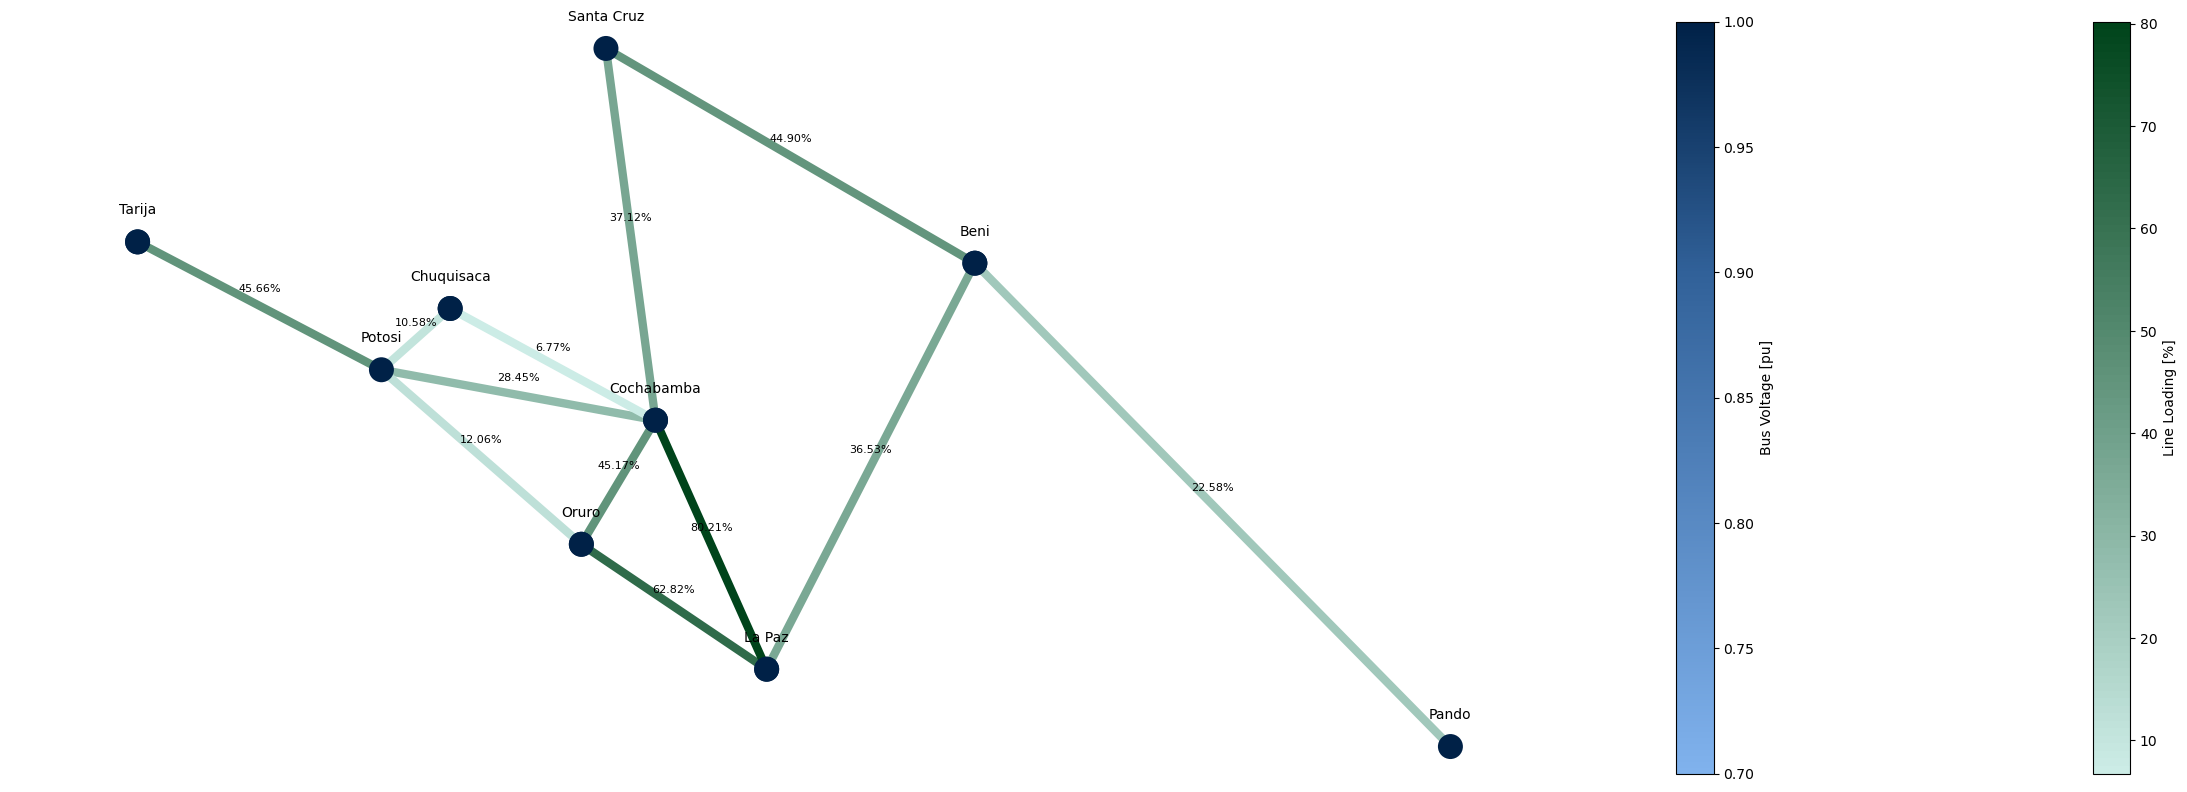

In [10]:
# Plot an advanced visual of the network showing the line loading results and voltage drops

import pandapower.plotting as plot
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import matplotlib as mpl

# Define the colors and number of bins for the custom colormap
colors = ["#ccece6", "#00441b"]
colors_2 = ["#fec44f", "#cc4c02"]
#colors_2 = ["#002147", "#002147"]
#002147
n_bins = 100  # Use 100 bins for the gradient
n_bins2 = 5

# Create a colormap object
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list("custom_colormap", colors_2, N=n_bins2)

# Creating the line color collection
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, linewidths=6)

# Creating the bus color collection
#bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap2)

# Creating the bus color collection
cmap_list=[(0.7, "#80b2ed"), (0.9, "#316199"), (1.0, "#002147")]
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

# Draw the collections
plot.draw_collections([lc, bc], figsize=(25,8))

# Calculate the loading percentage for each line
loading_percentages = net.res_line.loading_percent

# Get the midpoint of each line for the annotation
midpoints = np.array([((net.bus_geodata.loc[net.line.from_bus[i], 'x'] + net.bus_geodata.loc[net.line.to_bus[i], 'x']) / 2,
                       (net.bus_geodata.loc[net.line.from_bus[i], 'y'] + net.bus_geodata.loc[net.line.to_bus[i], 'y']) / 2)
                      for i in net.line.index])

# Annotate the plot with the loading percentages
for i, (x, y) in enumerate(midpoints):
    plt.annotate(f'{loading_percentages[i]:.2f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Annotate the plot with the bus names, excluding buses 9, 10, 11, 12, 13, and 14
excluded_buses = [9, 10, 11, 12, 13, 14]
for i in net.bus.index:
    if i not in excluded_buses:
        plt.annotate(net.bus.name.at[i], (net.bus_geodata.x.at[i], net.bus_geodata.y.at[i]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=10)

# Show the plot
plt.show()

In [11]:
# 60% load flow 
dispatch_perc = 60

# Create network
net = pp.create_empty_network() 
#Read bus data from excel
bus_df=pd.read_excel(r"bolivia python input.xlsx", sheet_name='buses',nrows=15)
#bus_df
# Create buses
b = {}

for i in bus_df['bus_id']:
    b[i] = pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0]),min_vm_pu=0.85)
net.bus

# Create one grid connection point
connect_bus = b[0] 
vm_pu = 1.1

# Create the external grid connection
pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")

# Import line data from excel file-- from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka

line_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='lines',nrows=12)
#line_df

# Create lines
for i in line_df.index:
    pp.create_line_from_parameters(net, from_bus=b[line_df.loc[i, 'from_bus']],
                                to_bus=b[line_df.loc[i, 'to_bus']],
                                length_km=line_df.loc[i, 'length_km'],
                                r_ohm_per_km=line_df.loc[i, 'r_ohm_per_km'],
                                x_ohm_per_km=line_df.loc[i, 'x_ohm_per_km'],
                                c_nf_per_km=line_df.loc[i, 'c_nf_per_km'],
                                max_i_ka=line_df.loc[i, 'max_i_ka']
                                ) 
net.line

# Import Load data from excel-- geolocation, bus (nearest from geolocation), p_mw
load_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='loads',nrows=9)
#load_df

# Create loads
p_mw = 'power_p_mw'
q_mvar = 'power_q_mvar'

for i in load_df['bus_id']:
    pp.create_load(net, 
                b[i], 
                p_mw=load_df.loc[load_df['bus_id']==i, p_mw].values[0], 
                q_mvar=load_df.loc[load_df['bus_id']==i, q_mvar].values[0],
                name=load_df.loc[load_df['bus_id']==i, 'name'].values[0])

net.bus

# Generators imported from excel
vm_pu=1.1

#### make the excel sheets in this style "gen 100"  "gen 95" etc. down from 100 to 50 in steps of 5
gen_df = pd.read_excel(r"bolivia python input.xlsx", sheet_name='gen',nrows=9)
print("sheet_name: ", 'gen ' + str(dispatch_perc))
#gen_df  

#Generators
for i in gen_df['gen_id']:
    pp.create_gen(net, bus=gen_df.loc[gen_df['gen_id']==i, 'bus_id'].values[0],
                p_mw=gen_df.loc[gen_df['gen_id']==i, 'p_mw_' + str(dispatch_perc)].values[0],vm_pu=1, 
                name=gen_df.loc[gen_df['gen_id']==i, 'name'].values[0])
net.gen

#USE THIS FOR TRANSFORMER- total of 6 transformers are created
# Define the voltage levels
vk_percent = 12
vkr_percent = 0.26
pfe_kw = 3.2
i0_percent = 0.06

# Create the transformers where voltage changes
pp.create_transformer_from_parameters(net, 0, 9, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 10, 2, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 3, 11, sn_mva=40, vn_hv_kv=230, vn_lv_kv=115, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 6, 12, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 13, 4, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)
pp.create_transformer_from_parameters(net, 14, 7, sn_mva=40, vn_hv_kv=115, vn_lv_kv=230, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)


# Set the voltage setpoint of all generators at bus 0 to 1.0 p.u.
net.gen.loc[net.gen.bus == 0, 'vm_pu'] = 1.0

# Set the voltage setpoint of all external grids at bus 0 to 1.0 p.u.
net.ext_grid.loc[net.ext_grid.bus == 0, 'vm_pu'] = 1.0

# Set the voltage setpoint of all DC lines at bus 0 to 1.0 p.u.
net.dcline.loc[net.dcline.from_bus == 0, 'vm_from_pu'] = 1.0
net.dcline.loc[net.dcline.to_bus == 0, 'vm_to_pu'] = 1.0


pp.runpp(net, algorithm='nr', max_iteration=10000, numba=False);



sheet_name:  gen 60


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


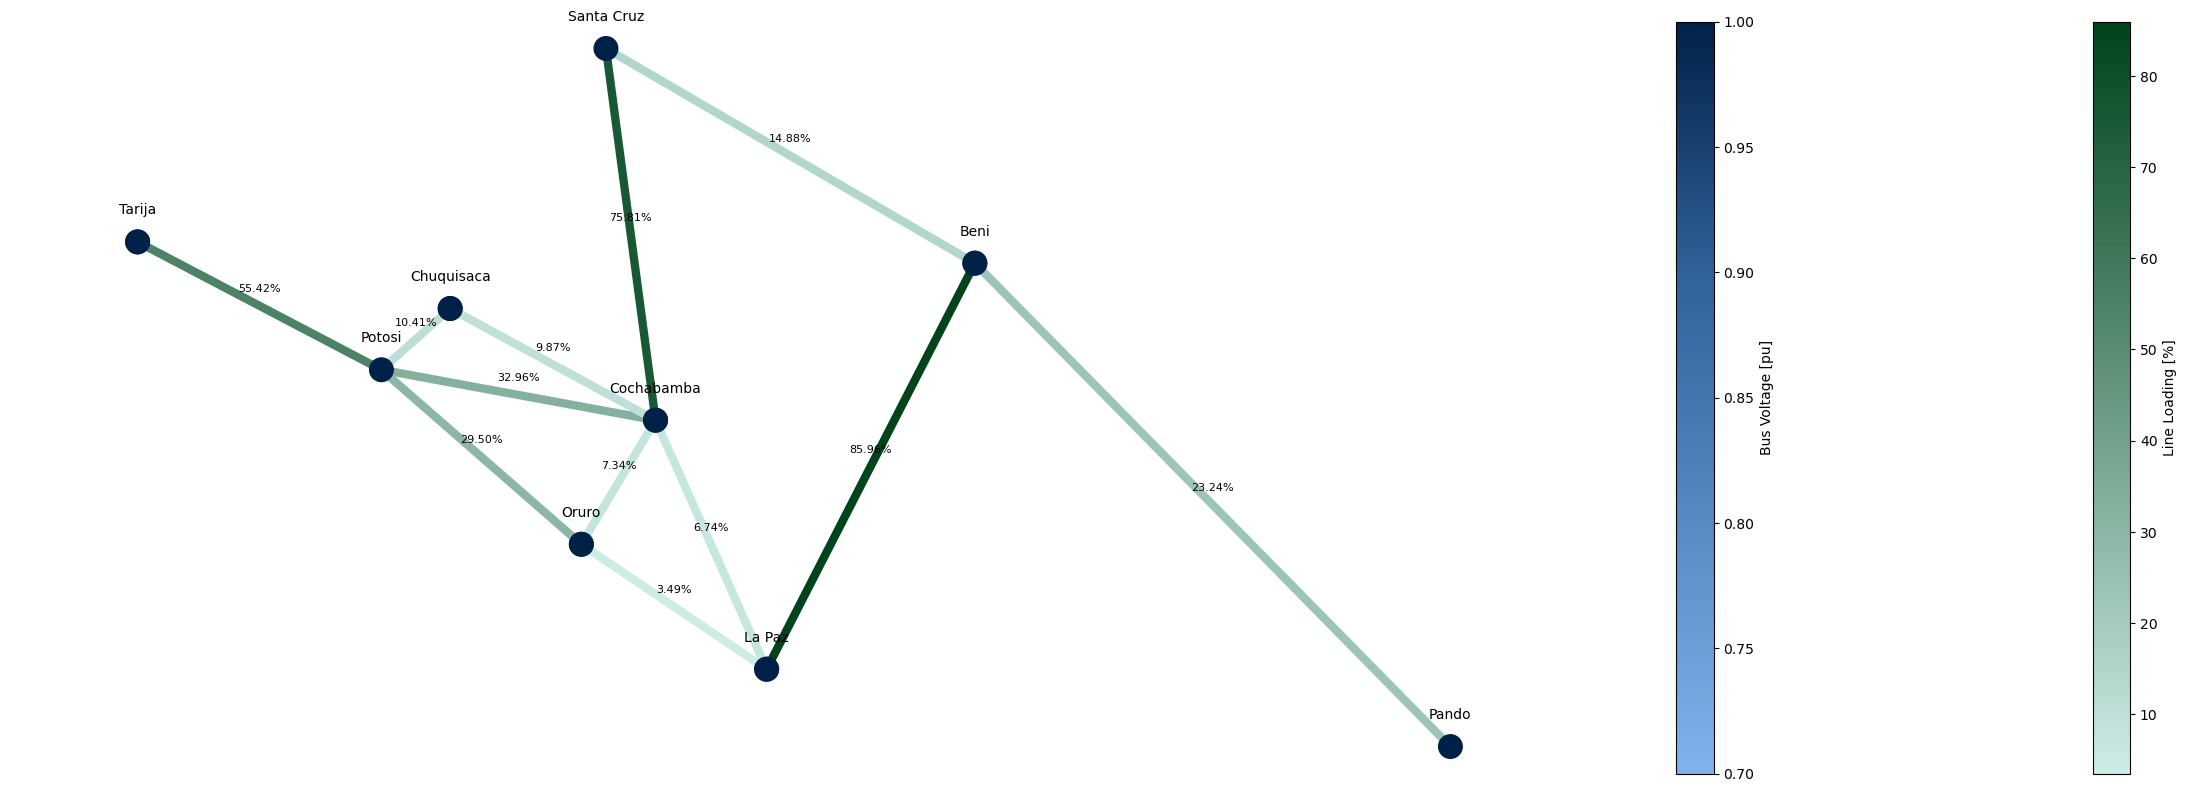

In [12]:
# Plot an advanced visual of the network showing the line loading results and voltage drops

import pandapower.plotting as plot
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import matplotlib as mpl

# Define the colors and number of bins for the custom colormap
colors = ["#ccece6", "#00441b"]
colors_2 = ["#fec44f", "#cc4c02"]
#colors_2 = ["#002147", "#002147"]
#002147
n_bins = 100  # Use 100 bins for the gradient

# Create a colormap object
cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_colormap", colors, N=n_bins)
cmap2 = mpl.colors.LinearSegmentedColormap.from_list("custom_colormap", colors_2, N=n_bins)

# Creating the line color collection
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, linewidths=6)

# Creating the bus color collection
#bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap2)

# Creating the bus color collection
cmap_list=[(0.7, "#80b2ed"), (0.9, "#316199"), (1.0, "#002147")]
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

# Draw the collections
plot.draw_collections([lc, bc], figsize=(25,8))

# Calculate the loading percentage for each line
loading_percentages = net.res_line.loading_percent

# Get the midpoint of each line for the annotation
midpoints = np.array([((net.bus_geodata.loc[net.line.from_bus[i], 'x'] + net.bus_geodata.loc[net.line.to_bus[i], 'x']) / 2,
                       (net.bus_geodata.loc[net.line.from_bus[i], 'y'] + net.bus_geodata.loc[net.line.to_bus[i], 'y']) / 2)
                      for i in net.line.index])

# Annotate the plot with the loading percentages
for i, (x, y) in enumerate(midpoints):
    plt.annotate(f'{loading_percentages[i]:.2f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Annotate the plot with the bus names, excluding buses 9, 10, 11, 12, 13, and 14
excluded_buses = [9, 10, 11, 12, 13, 14]
for i in net.bus.index:
    if i not in excluded_buses:
        plt.annotate(net.bus.name.at[i], (net.bus_geodata.x.at[i], net.bus_geodata.y.at[i]), textcoords="offset points", xytext=(0,20), ha='center', fontsize=10)

# Show the plot
plt.show()

In [13]:
#displaying power flow results
net

This pandapower network includes the following parameter tables:
   - bus (15 element)
   - load (9 element)
   - gen (9 element)
   - ext_grid (1 elements)
   - line (12 element)
   - trafo (6 element)
   - bus_geodata (15 element)
 and the following results tables:
   - res_bus (15 element)
   - res_line (12 element)
   - res_trafo (6 element)
   - res_ext_grid (1 elements)
   - res_load (9 element)
   - res_gen (9 element)

In [14]:
# Display bus results
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-406.321784,-205.884827
1,1.000000,-108.792553,144.784888,-85.339408
2,1.000000,-63.481024,329.160881,-412.421308
3,1.000000,1.685809,-60.816788,4.506955
4,1.000000,3.397863,-789.741373,-148.569569
5,1.000000,-49.910714,344.080574,-308.569046
6,1.000000,-5.454930,30.915609,-134.535055
7,1.000000,-0.708462,39.234410,-8.310623
8,1.000000,-70.347296,152.795640,-129.609813
9,0.999964,-0.000231,0.000000,0.000000


In [15]:
# Display line results
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,-387.551147,342.273866,479.301409,193.952209,91.750262,536.226075,1.297924,1.297925,1.297925,1.0,-63.481024,1.0,0.000000,85.955266
1,-24.912629,3.813572,25.014037,-3.079062,0.101408,0.734510,0.063265,0.063265,0.063265,1.0,0.000000,1.0,1.685809,3.485654
2,-48.070196,8.095261,48.465491,-5.231989,0.395295,2.863272,0.122366,0.122366,0.122366,1.0,0.000000,1.0,3.397863,6.741918
3,-52.432413,8.038563,52.649172,-6.468493,0.216759,1.570069,0.133155,0.133155,0.133155,1.0,1.685809,1.0,3.397863,7.336345
4,518.920198,176.594144,-451.662171,310.588054,67.258026,487.182197,1.375965,1.375965,1.375965,1.0,3.397863,1.0,-49.910714,75.810766
5,107.581597,-2.019008,-104.104483,27.205349,3.477114,25.186342,0.270101,0.270101,0.270101,1.0,-49.910714,1.0,-63.481024,14.881591
6,98.710667,-9.127765,-96.130000,24.210189,2.580666,15.082423,0.248842,0.497685,0.497685,1.0,3.397863,1.0,-5.454930,32.959263
7,88.231965,-9.490240,-86.367919,20.384441,1.864045,10.894201,0.222759,0.445518,0.445518,1.0,1.685809,1.0,-5.454930,29.504502
8,-30.618427,6.554366,31.055777,-3.998317,0.437350,2.556048,0.157200,0.078600,0.157200,1.0,-5.454930,1.0,-0.708462,10.410625
9,70.992646,-7.220112,-70.293387,12.285155,0.699260,5.065044,0.179126,0.179126,0.179126,1.0,3.397863,1.0,-0.708462,9.869219


In [16]:
#displaying transformer results
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
0,3.199790e-03,2.378487e-02,2.288260e-19,5.684139e-14,0.0032,0.023785,6.024309e-05,2.853788e-16,1.000000,0.000000,0.999964,-0.000231,0.059998
1,-7.624015e-14,2.548186e-14,3.199790e-03,2.378487e-02,0.0032,0.023785,4.035866e-16,6.024309e-05,0.999964,-63.481254,1.000000,-63.481024,0.059998
2,3.199790e-03,2.378487e-02,1.671970e-15,-5.681679e-14,0.0032,0.023785,6.024309e-05,2.853788e-16,1.000000,1.685809,0.999964,1.685579,0.059998
3,3.199790e-03,2.378487e-02,3.536497e-15,-3.377328e-16,0.0032,0.023785,1.204862e-04,8.918088e-18,1.000000,-5.454930,0.999964,-5.455161,0.059998
4,3.368712e-15,-5.674147e-14,3.199790e-03,2.378487e-02,0.0032,0.023785,2.853788e-16,6.024309e-05,0.999964,3.397633,1.000000,3.397863,0.059998
5,1.591133e-15,5.682605e-14,3.199790e-03,2.378487e-02,0.0032,0.023785,2.854136e-16,6.024309e-05,0.999964,-0.708693,1.000000,-0.708462,0.059998
